# **Deep Hedging**
# Buchkov Viacheslav

In [ ]:
!git clone https://github.com/v-buchkov/deep-hedging.git

Cloning into 'deep-hedging'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 542 (delta 195), reused 306 (delta 119), pack-reused 154
Receiving objects: 100% (542/542), 71.19 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [ ]:
import sys

sys.path.insert(0, "/content/deep-hedging")

In [ ]:
from pathlib import Path

from deep_hedging import ExperimentConfig, EuropeanCall, seed_everything
from deep_hedging.dl import SpotDataset, Trainer, Assessor
from deep_hedging.dl.models import LSTMHedger
from deep_hedging.dl.baselines import BaselineEuropeanCall

RANDOM_SEED = 12

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

PATH = Path("/content/gdrive/MyDrive/")

Mounted at /content/gdrive


In [ ]:
config = ExperimentConfig(
    RANDOM_SEED=RANDOM_SEED, DATA_ROOT=PATH, OUTPUT_ROOT=Path("."), DATA_FILENAME="2024"
)
seed_everything(RANDOM_SEED)

config.DEVICE

device(type='cuda')

In [ ]:
print(config)

ExperimentConfig(N_DAYS=5, REBAL_FREQ='30 min', VAR_QUANTILE=0.05, TEST_SIZE=0.1, RANDOM_SEED=12, DATA_ROOT=PosixPath('/content/gdrive/MyDrive'), OUTPUT_ROOT=PosixPath('.'), DATA_FILENAME='2024', LAYER_NORM=False, USE_TIME_DIFF=True, USE_SPOT_START=True, N_EPOCHS=20, N_STEPS_RL_TRAIN=1000000, LR=0.01, BATCH_SIZE=32, NUM_LAYERS=3, HIDDEN_DIM=32, EMBED_MAX_DIM=128, OPTIMIZER=<class 'torch.optim.adam.Adam'>, NUM_WORKERS=2)


## Dataset.

In [ ]:
spot_dataset = SpotDataset(
    n_days=config.N_DAYS, instrument_cls=EuropeanCall, config=config
)
spot_dataset.df.head()

,bid,ask,rub_rate,usd_rate,time_diff
timestamp,,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,0.081265,0.00672,0.000000
2017-01-03 07:01:00+00:00,61.010855,61.068045,0.081265,0.00672,0.000002
2017-01-03 07:02:00+00:00,61.037220,61.069850,0.081265,0.00672,0.000004
2017-01-03 07:03:00+00:00,61.011955,61.048690,0.081265,0.00672,0.000006
2017-01-03 07:04:00+00:00,61.021250,61.052835,0.081265,0.00672,0.000008


## Run.

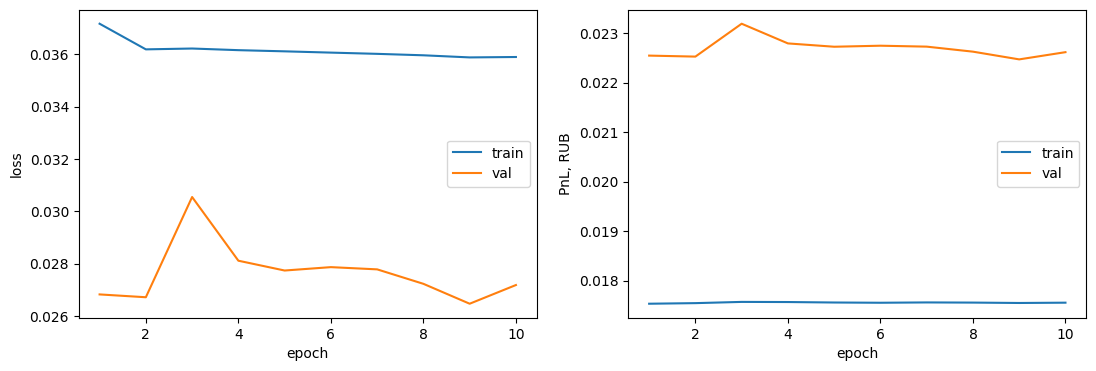

In [ ]:
N_EPOCHS = 10
config.REBAL_FREQ = "30 min"

trainer = Trainer(model_cls=LSTMHedger, instrument_cls=EuropeanCall, config=config)
trainer.run(N_EPOCHS)

## Baseline check.

In [ ]:
%load_ext autoreload
%autoreload 2

Average weight = 0.605722188949585, Weights = [0.605722188949585; 0.605722188949585]
Means: model = 0.723032, baseline = 0.815242
Stds: model = 0.588400, baseline = 0.469759
VaRs 5%: model = -0.119151, baseline = -0.319755
T-stat = -13.744453


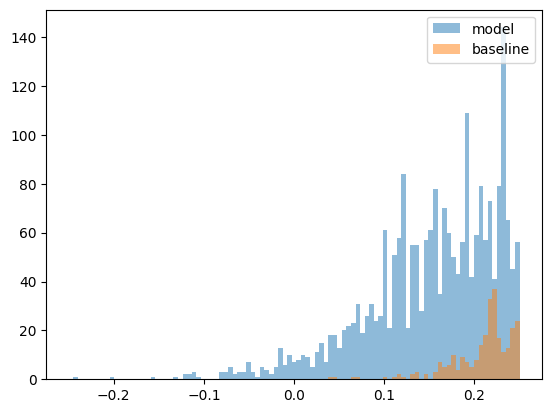

In [ ]:
from deep_hedging.dl import Assessor

assessor = Assessor(
    model=trainer.hedger,
    baseline=BaselineEuropeanCall(dt=trainer.dt).to(config.DEVICE),
    test_loader=trainer.test_loader,
)
assessor.run()

In [ ]:
trainer.save(config.OUTPUT_ROOT)